# Import Libraries


In [2]:
import h5py as h5py
import torch
import numpy as np
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

# Dataset

## Load Dataset

In [3]:
# Download the dataset
# ! wget https://drive.google.com/file/d/1LcKqf1d7bctw5lx0YZf31kCUF0zEYOsi/view?usp=sharing

In [4]:
f = h5py.File('MNIST_synthetic.h5', 'r')

X_train = torch.tensor(f['train_dataset'][...]).permute(0, 3, 1, 2).contiguous()
y_train = torch.tensor(f['train_labels'][...])
X_test = torch.tensor(f['test_dataset'][...]).permute(0, 3, 1, 2).contiguous()

# These are the tensors for our 2nd CNN which predicts the number of digits in an image
X_train2 = torch.tensor(f['train_dataset'][...])
y_train2 = torch.tensor(f['train_labels'][...])
X_test2 = torch.tensor(f['test_dataset'][...])


# can refactor to map lambda, same performance
def count_digits(tensor):
    counter = 0
    for i,t in enumerate(tensor):
        if tensor[i] != 10:
            counter += 1
    return counter


def count_num_digits(labels):
    new_labels = torch.empty(len(y_train2), 1 , dtype=torch.int32)
    for i,t in enumerate(labels):
        new_labels[i] = count_digits(t)
    return new_labels

num_of_digits = count_num_digits(y_train2)


print(f'X_train.shape: {X_train.shape}, dtype {X_train.dtype}')
print(f'y_train.shape: {y_train.shape}, dtype {y_train.dtype}')
print(f'X_test.shape: {X_test.shape}, dtype {X_test.dtype}')

X_train.shape: torch.Size([56000, 1, 64, 64]), dtype torch.uint8
y_train.shape: torch.Size([56000, 5]), dtype torch.int32
X_test.shape: torch.Size([14000, 1, 64, 64]), dtype torch.uint8


## Preprocess Data


In [5]:
def scale(tensor):
    """
    [0, 255] -> [-1, 1]
    """
    return (tensor.to(torch.float32) * 2 / 255) - 1

def descale(tensor):
    """
    [-1, 1] -> [0, 255]
    """
    return ((tensor + 1) * 255 / 2).to(torch.uint8)

def visualize_tensor(tensor):
    """
    visualize a tensor of shape (H, W, 1). Must be in range [-1, 1] or [0, 255].
    """
    if tensor.dtype == torch.float32:
        tensor = descale(tensor)
    array = tensor.permute(1, 2, 0).contiguous().numpy()
    plt.imshow(array, cmap='Greys_r')
    plt.show()

In [15]:
digit_size = 12  # 64 // 5
crop_h_start = (64 // 2) - (digit_size // 2)
crop_h_end = crop_h_start + digit_size +1  # +1 is safety margin
crop_w_start = 2
crop_w_end = -2

def split_digits(tensor, num_digits, digit_size=digit_size):
    """
    splits a single image of `num_digits` digits to multiple images
    """
    start_index = (5 - num_digits) * digit_size // 2
    end_index = start_index + (num_digits * digit_size)
    tensor = tensor[..., start_index: end_index]
    return torch.stack(torch.chunk(tensor, num_digits, dim=2))

# remove padding and rescale
X_train_processed = scale(X_train[..., crop_h_start: crop_h_end, crop_w_start: crop_w_end])
y_train_processed = y_train.to(torch.int64)
X_test_processed = scale(X_test[..., crop_h_start: crop_h_end, crop_w_start: crop_w_end])


# TODO: Create validation set randomly (with a fixed random seed) and val_loader
num_digits_train_dataset = None
num_digits_train_loader = None
num_digits_val_dataset = None
num_digits_val_loader = None
"""
dataset = TensorDataset(X_train_processed, y_train_processed)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
"""

# TODO: create a new dataset and loader from the previous dataset by splitting all digits and stacking them all together
# such that the new dataset is of shape (number of total digits x 1 x 28 x 28)
digits_train_dataset = None
digits_train_loader = None
digits_val_dataset = None
digits_val_loader = None

test_loader = DataLoader(X_test_processed, batch_size=4)

# Class to represent our dataset and be used with dataloader
class CustomMNISTDataset(TensorDataset):
    def __init__(self):
        self.len = len(X_train_processed)
        self.x_data = X_train_processed
        self.y_data = y_train_processed

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# Class for our second CNN to predict the number of digits in an iamge
class NumberOfDigitsDataset(TensorDataset):
    def __init__(self):
        self.len = len(X_train)
        self.x_data = X_train2
        self.y_data = num_of_digits

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

dataset = CustomMNISTDataset()
dataset2 = NumberOfDigitsDataset()
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4,
                                          shuffle=True, num_workers=0, pin_memory=True)

train_loader2= torch.utils.data.DataLoader(dataset=dataset2, batch_size=4,
                                          shuffle=True, num_workers=0, pin_memory=True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 61)

Raw X_train
------

Preprocessed X_train
Label: tensor([ 9, 10, 10, 10, 10])
Splitted


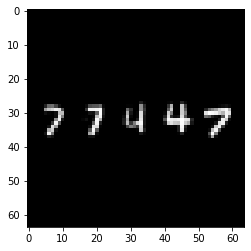

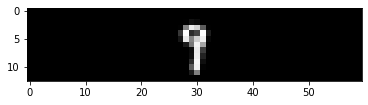

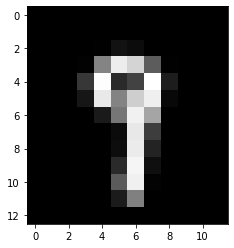

In [7]:
print('Raw X_train')
visualize_tensor(X_train[102])
print('------\n')
print('Preprocessed X_train')
x_sample, y_sample = next(iter(train_loader))
print(f'Label: {y_sample[0]}')
visualize_tensor(x_sample[0])
print('Splitted')
num_digits = torch.sum(y_sample[0] != 10).item()
splitted_digits = split_digits(x_sample[0], num_digits)
for digit in splitted_digits:
    visualize_tensor(digit)

# Convolutional neural network


In [8]:
# TODO: STEP 1
# Train a NN to predict num_digits in each sample. I.e. input would be X from num_digits_train_dataset, output would be
# torch.sum(y[0] != 10).item()
# This model should have accuracy very close to 100% (>99% on validation)
# IF IT DOESN'T, MIGHT NEED DATA AUGMENTATION HERE
# Track validation accuracy during training to avoid overfitting (stop training when
# validation accuracy starts to decrease)
# FANCY TIPS: Use batchnorm layers, lookup VGG/RESNET architecture

# TODO: STEP 2
# Train a NN to predict each 12x12 digit in digits_train_dataset
# Track validation accuracy during training to avoid overfitting (stop training when
# validation accuracy starts to decrease)
# FANCY TIPS: Use batchnorm layers, lookup VGG/RESNET architecture

# TODO: STEP 3
# Make num_digits prediction for X_test based on model in STEP1, then use `split_digits()` function 
# with the predicted number of digits to split the digits, then make a prediction for each digit
# separately by using the model trained in STEP 2. Convert the predictions from e.g. 2, 3
# into the required format e.g. [2, 3, 10, 10, 10]

# TODO: STEP 4
# Convert predictions into whatever Excel format is required for uploading to Kaggle

# TODO: EXTRA IMPROVEMENTS
# - Data Augmentation

In [9]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# # model 0
# num_filters = 8
# filter_size = 5
# pool_size = 4

# model = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels=1,
#                     out_channels=num_filters,
#                     kernel_size=filter_size,
#                     padding=filter_size // 2),
#     torch.nn.ReLU(),
#     torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
#     torch.nn.Flatten(),
#     torch.nn.Linear(num_filters * 64**2 // pool_size**2, 10),
# )


# model 1
num_filters = [6, 16]
filter_size = 3
pool_size = 2
mlp_size = [16*14*14, 120, 84, 5 * 11]

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,
                    out_channels=num_filters[0],
                    kernel_size=filter_size,
                    padding=filter_size // 2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    # torch.nn.Conv2d(in_channels=num_filters[0],
    #                 out_channels=num_filters[1],
    #                 kernel_size=filter_size,
    #                 padding=filter_size // 2),
    # torch.nn.ReLU(),
    # torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(1080, mlp_size[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[1], mlp_size[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[2], mlp_size[3]),
)


print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=1080, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): ReLU()
  (8): Linear(in_features=84, out_features=55, bias=True)
)


### Loss function and Optimizer


In [10]:
# cross entropy is pretty good for classification problems
# discuss pros of cross entropy in the report
criterion = nn.CrossEntropyLoss()
# might need to play a bit with learning rate and momentum if needed
# SGD is computationally efficient
# GD is terrible, uses too much memory
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters())  # converges faster and less sensitive to lr, generalizes (typiaclly) worse

### Training CNN


In [11]:
# loop over dataset multiple times
# model.train()
for epoch in range(4):
    running_loss = 0 # counter
    # get inputs, data is a list of [inputs, labels]
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        # loss = criterion(outputs, labels)
        loss = 0
        for j in range(5):
            loss += criterion(outputs[:, (j * 11):((j + 1) * 11)], labels[:, j])

        loss.backward() # computing gradients wrt model's weights
        optimizer.step() # update using learning rate

        # print statistics
        running_loss += loss.item()
        # print every 2000 minibatches
        if i % 2000 == 1999:
            print('[%d, %5d loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0

print('Done')

[1,  2000 loss: 6.297
[1,  4000 loss: 4.130
[1,  6000 loss: 3.285


KeyboardInterrupt: 

In [ ]:
model.eval()
test_input = next(iter(test_loader))
test_output = model(test_input)

In [ ]:
def output_to_label(output):
    labels = [torch.argmax(output[:, (j * 11):((j + 1) * 11)], dim=1) for j in range(5)]
    return torch.stack(labels)
test_pred_labels = output_to_label(test_output)

In [ ]:
test_pred_labels

In [ ]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# # model 0
# num_filters = 8
# filter_size = 5
# pool_size = 4

# model = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels=1,
#                     out_channels=num_filters,
#                     kernel_size=filter_size,
#                     padding=filter_size // 2),
#     torch.nn.ReLU(),
#     torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
#     torch.nn.Flatten(),
#     torch.nn.Linear(num_filters * 64**2 // pool_size**2, 10),
# )


# model 1
num_filters = [6, 16]
filter_size = 3
pool_size = 2
mlp_size = [4096, 120, 84, 5 * 11]

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,
                    out_channels=num_filters[0],
                    kernel_size=filter_size,
                    padding=filter_size // 2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    torch.nn.Conv2d(in_channels=num_filters[0],
                    out_channels=num_filters[1],
                    kernel_size=filter_size,
                    padding=filter_size // 2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(720, mlp_size[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[1], mlp_size[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[2], mlp_size[3]),
)


print(model)

### Loss function and Optimizer


In [ ]:
# cross entropy is pretty good for classification problems
# discuss pros of cross entropy in the report
criterion = nn.CrossEntropyLoss()
# might need to play a bit with learning rate and momentum if needed
# SGD is computationally efficient
# GD is terrible, uses too much memory
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters())  # converges faster and less sensitive to lr, generalizes (typiaclly) worse

### Training CNN


In [ ]:
# loop over dataset multiple times
# model.train()
for epoch in range(4):
    running_loss = 0 # counter
    # get inputs, data is a list of [inputs, labels]
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # loss = criterion(outputs, labels)
        loss = 0
        for j in range(5):
            loss += criterion(outputs[:, (j * 11):((j + 1) * 11)], labels[:, j])

        loss.backward() # computing gradients wrt model's weights
        optimizer.step() # update using learning rate

        # print statistics
        running_loss += loss.item()
        # print every 2000 minibatches
        if i % 2000 == 1999:
            print('[%d, %5d loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0

print('Done')

In [ ]:
model.eval()
test_input = next(iter(test_loader))
test_output = model(test_input)

In [ ]:
def output_to_label(output):
    labels = [torch.argmax(output[:, (j * 11):((j + 1) * 11)], dim=1) for j in range(5)]
    return torch.stack(labels)
test_pred_labels = output_to_label(test_output)

In [ ]:
test_pred_labels

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))